## Tampa Bay, FL - Detailed step-by-step

### Standardize, clean and wrangle Water Quality Portal data in Tampa Bay, FL into more analytic-ready formats using the harmonize_wq package

US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:
- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

### Detailed step-by-step workflow

This example workflow takes a deeper dive into some of the expanded functionality to examine results for different water quality parameters in Tampa Bay, FL

#### Install and import the required libraries

In [1]:
import sys
#!python -m pip uninstall harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
#!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git@new_release_0-3-8

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle
from harmonize_wq import location
from harmonize_wq import harmonize
from harmonize_wq import visualize
from harmonize_wq import clean

/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/dataretrieval/nadp.py:44: UserWarning: GDAL not installed. Some functions will not work.
  warnings.warn('GDAL not installed. Some functions will not work.')


#### Download location data using dataretrieval

<Axes: >

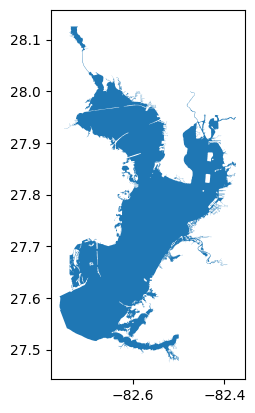

In [3]:
# Read geometry for Area of Interest from geojson file url and plot
aoi_url = r'https://github.com/USEPA/Coastal_Ecological_Indicators/raw/master/DGGS_Coastal/temperature_data/TampaBay.geojson'
# geoJSON should be WGS1984 standard, but this one isn't
aoi_gdf = wrangle.as_gdf(aoi_url).to_crs(epsg=4326)
aoi_gdf.plot()

In [4]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] =wrangle.get_bounding_box(aoi_gdf)

In [5]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [6]:
# Rows and columns for results
stations.shape

(16023, 37)

In [7]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-FL,USGS Florida Water Science Center,USGS-02300009,MANATEE RIVER AT DEVILS ELBOW NEAR FT HAMER FL,Estuary,NaN,3100202.0,139.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-FL,USGS Florida Water Science Center,USGS-02300018,GAMBLE CREEK NEAR PARRISH FL,Stream,NaN,3100202.0,50.6,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-FL,USGS Florida Water Science Center,USGS-02300021,MANATEE RIVER AT FORT HAMER FL,Estuary,NaN,3100202.0,216.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-FL,USGS Florida Water Science Center,USGS-02300062,GLEN CREEK NEAR BRADENTON FL,Stream,NaN,3100202.0,2.5,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-FL,USGS Florida Water Science Center,USGS-02300064,BRADEN RIVER AT BRADENTON FL,Stream,NaN,3100202.0,83.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [8]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 27.520872
LongitudeMeasure                                -82.40176
Name: 0, dtype: object

In [9]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, outEPSG=4326, intermediate_columns=True)

In [10]:
# Every function has a dostring to help understand input/output and what it does
location.harmonize_locations?

In [11]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(16023, 42)

In [12]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-82.4017604, 27.5208719)
EPSG                                 4269.0
QA_flag                                 NaN
geom         POINT (-82.4017604 27.5208719)
geometry     POINT (-82.4017604 27.5208719)
Name: 0, dtype: object

In [13]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [14]:
# Look at the different QA_flag flags that have been assigned,
# e.g., for bad datums or limited decimal precision
set(stations_gdf.loc[stations_gdf['QA_flag'].notna()]['QA_flag'])

{'HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed',
 'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed'}

<Axes: >

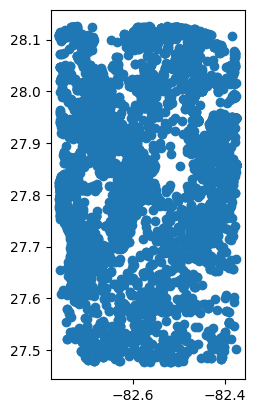

In [15]:
# Map it
stations_gdf.plot()

In [16]:
# Clip it to area of interest
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<Axes: >

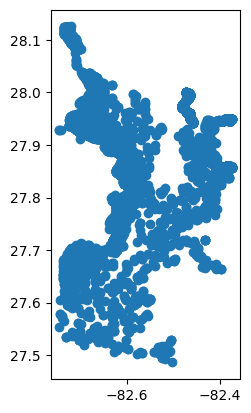

In [17]:
# Map it
stations_clipped.plot()

In [18]:
# How many stations now?
len(stations_clipped)

10564

In [19]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path, 'Tampa_stations.shp'))

#### Retrieve Characteristic Data

In [20]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/dataretrieval/wqp.py:83: DtypeWarning: Columns (9,10,13,15,17,19,22,23,28,31,32,33,36,38,58,60,61,63,64,65,70,71,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')


In [21]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130612585-W,2013-06-12,11:01:00,EST,21FLHILL_WQX-585,STORET-301235413,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-481901119134,2013-11-19,14:01:00,EST,21FLSEAS_WQX-48SEAS190,STORET-310535134,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130702047-M,2013-07-02,11:01:00,EST,21FLHILL_WQX-047,STORET-300620295,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130716021,2013-07-16,11:01:00,EST,21FLHILL_WQX-021,STORET-300666279,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
4,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-131216112-M,2013-12-16,12:01:00,EST,21FLHILL_WQX-112,STORET-301229196,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465643,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6842541,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1465644,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6842544,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1465645,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800924,1957-10-21,14:05:00,EST,USGS-02306001,NWIS-6894410,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1465646,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500782,1955-04-08,NaN,NaN,USGS-274455082253601,NWIS-6842941,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


<Axes: >

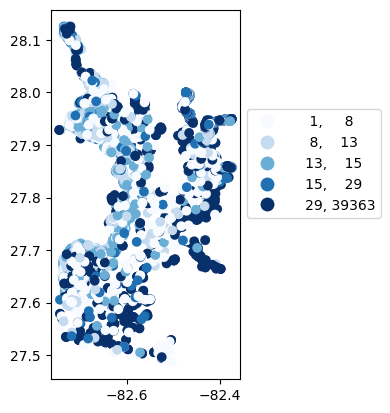

In [22]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
legend_kwds = {"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize(). harmonize_all runs functions on all characteristics and lets you specify how to handle errors harmonize runs functions only on the characteristic specified with char_val and lets you also choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [23]:
# See Documentation
#harmonize.harmonize_all?
#harmonize.harmonize?

##### secchi disk depth

/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'None' UNDEFINED UNIT for Secchi
  warn("WARNING: " + problem)


-Usable results-
count    86883.000000
mean         1.470456
std          0.901391
min         -9.000000
25%          0.900000
50%          1.300000
75%          1.900000
max         32.004000
dtype: float64
Unusable results: 219
Usable results with inferred units: 0
Results outside threshold (0.0 to 6.8787994128969): 47


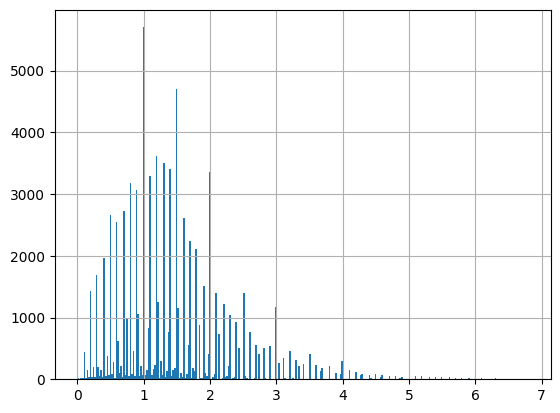

In [24]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [25]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
78,21FLHILL_WQX-171,0.60,m,NaN,m,0.6 meter
103,21FLHILL_WQX-092,5.00,m,NaN,m,5.0 meter
118,21FLHILL_WQX-161,0.50,m,NaN,m,0.5 meter
130,21FLHILL_WQX-14434,1.30,m,NaN,m,1.3 meter
132,21FLCOSP_WQX-COSPE6-4,2.6,m,NaN,m,2.6 meter
...,...,...,...,...,...,...
1465327,21FLBSG-4,1,m,NaN,m,1.0 meter
1465328,21FLBSG-4,1.1,m,NaN,m,1.1 meter
1465329,21FLBSG-4,1.5,m,NaN,m,1.5 meter
1465330,21FLBSG-4,1.4,m,NaN,m,1.4 meter


In [26]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
661231,21FLPDEM_WQX-14-02,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
666285,21FLKWAT_WQX-HIL-RAINBOW-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
669267,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-8,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
671238,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-6,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
672987,21FLPDEM_WQX-E2-D-19-02,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
1458855,21FLKWAT_WQX-HIL-CHURCH-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
1459179,21FLKWAT_WQX-HIL-ARMISTEAD-3,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
1459995,21FLKWAT_WQX-HIL-CHURCH-3,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
1460570,21FLKWAT_WQX-HIL-ARMISTEAD-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN


In [27]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used'

In [28]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
244360,NARS_WQX-NCCA10-1674,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
661231,21FLPDEM_WQX-14-02,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
666285,21FLKWAT_WQX-HIL-RAINBOW-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
669267,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-8,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
671238,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-6,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
1458855,21FLKWAT_WQX-HIL-CHURCH-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
1459179,21FLKWAT_WQX-HIL-ARMISTEAD-3,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
1459995,21FLKWAT_WQX-HIL-CHURCH-3,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
1460570,21FLKWAT_WQX-HIL-ARMISTEAD-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN


If both value and unit are missing nothing can be done, a unitless (NaN) value is assumed as to be in default units but a QA_flag is added

In [29]:
# Aggregate secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,2,0.375000
1,21FLBRA-1541B-A,3,1.166667
2,21FLBRA-1574-A,1,0.250000
3,21FLBRA-1574A-A,2,0.250000
4,21FLBRA-1574A-B,1,1.250000
...,...,...,...
11680,USGS-280630082350900,3,1.966667
11681,USGS-280635082322100,2,2.100000
11682,USGS-280640082434700,3,2.302933
11683,USGS-280719082291400,2,1.000000


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  self.bins = quantile(y, k=k)


<Axes: >

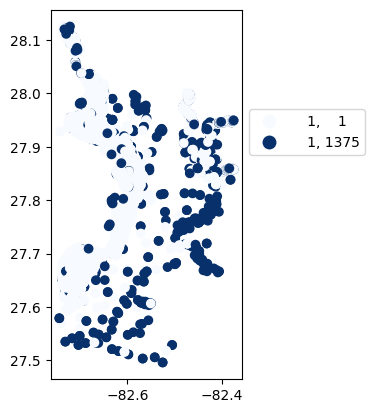

In [30]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

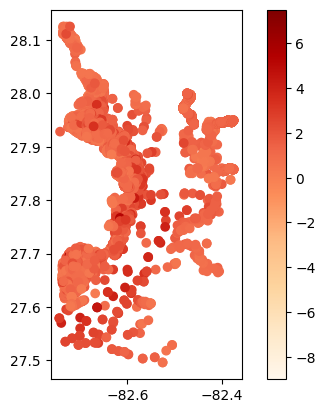

In [31]:
# Map average results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

-Usable results-
count    300062.000000
mean         25.306539
std          79.896745
min          -2.900000
25%          21.200000
50%          25.900000
75%          29.200000
max       43696.000000
dtype: float64
Unusable results: 153
Usable results with inferred units: 0
Results outside threshold (0.0 to 504.6870062954504): 2


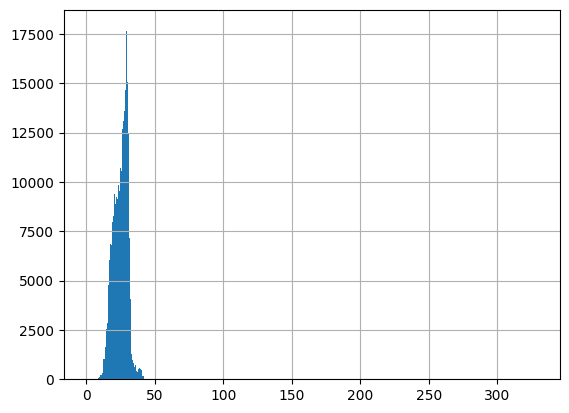

In [32]:
#'Temperature, water'
# Note: Default errors='raise'
df = harmonize.harmonize(df, 'Temperature, water', intermediate_columns=True, report=True)

In [33]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
2,21FLHILL_WQX-047,28.19,deg C,NaN,28.19 degree_Celsius,degC
23,21FLHILL_WQX-1509,27.67,deg C,NaN,27.67 degree_Celsius,degC
25,21FLHILL_WQX-060,30.24,deg C,NaN,30.24 degree_Celsius,degC
27,21FLTBW_WQX-NAB,30.67,deg C,NaN,30.67 degree_Celsius,degC
28,21FLTBW_WQX-DISM,26.5,deg C,NaN,26.5 degree_Celsius,degC
...,...,...,...,...,...,...
1465632,USGS-273217082335701,28.9,deg C,NaN,28.9 degree_Celsius,degC
1465635,USGS-274322082245501,24.4,deg C,NaN,24.4 degree_Celsius,degC
1465640,USGS-274302082280801,25.0,deg C,NaN,25.0 degree_Celsius,degC
1465643,USGS-273926082304501,25.7,deg C,NaN,25.7 degree_Celsius,degC


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [34]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
665577,21FLPDEM_WQX-19-13,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
666462,21FLPDEM_WQX-24-07,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
667856,21FLPDEM_WQX-12-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
673026,21FLPDEM_WQX-23-08,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
679058,21FLPDEM_WQX-04-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
...,...,...,...,...,...,...
892842,21FLPDEM_WQX-35-01,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
896988,21FLPDEM_WQX-23-08,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1349634,USGS-280228082343000,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC
1434517,USGS-02306028,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [35]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used; ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [36]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
665577,21FLPDEM_WQX-19-13,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
666462,21FLPDEM_WQX-24-07,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
667856,21FLPDEM_WQX-12-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
673026,21FLPDEM_WQX-23-08,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
679058,21FLPDEM_WQX-04-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
...,...,...,...,...,...,...
1460117,21FLPDEM_WQX-06-06,Not Reported,deg C,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1460141,21FLPDEM_WQX-12-02,Not Reported,deg C,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1460148,21FLPDEM_WQX-W7-D-23-08,Not Reported,deg C,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1460229,21FLPDEM_WQX-12-06,Not Reported,deg C,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC


In [37]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,12,27.593333
1,21FLBRA-1530-B,7,26.290000
2,21FLBRA-1541A-A,6,26.016667
3,21FLBRA-1541B-A,6,26.743333
4,21FLBRA-1574-A,5,27.890000
...,...,...,...
14839,USGS-280726082313300,4,28.025000
14840,USGS-280728082301101,54,25.083333
14841,USGS-280729082313501,1,27.400000
14842,USGS-280730082313201,1,24.700000


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


<Axes: >

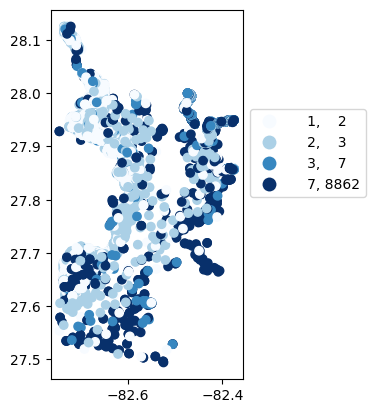

In [38]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

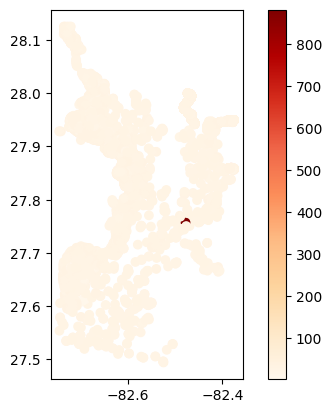

In [39]:
# Map average results at each station
gdf_avg = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Dissolved oxygen

In [40]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize(df, 'Dissolved oxygen (DO)')

Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [41]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
0,21FLHILL_WQX-585,9.32,mg/L,NaN,9.32 milligram / liter
9,21FLHILL_WQX-1611,4.90,mg/L,NaN,4.9 milligram / liter
11,21FLHILL_WQX-1606,2.56,mg/L,NaN,2.56 milligram / liter
14,21FLPDEM_WQX-24-01,68.7,%,NaN,0.05676222371166 milligram / liter
19,21FLTBW_WQX-DISN,6.36,mg/L,NaN,6.36 milligram / liter
...,...,...,...,...,...
1465348,21FLBSG-4,4,mg/l,NaN,4.0 milligram / liter
1465349,21FLBSG-4,7.2,mg/l,NaN,7.2 milligram / liter
1465350,21FLBSG-4,7.4,mg/l,NaN,7.4 milligram / liter
1465351,21FLBSG-4,7.9,mg/l,NaN,7.9 milligram / liter


In [42]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
0,21FLHILL_WQX-585,9.32,mg/L,NaN,9.32 milligram / liter
9,21FLHILL_WQX-1611,4.90,mg/L,NaN,4.9 milligram / liter
11,21FLHILL_WQX-1606,2.56,mg/L,NaN,2.56 milligram / liter
14,21FLPDEM_WQX-24-01,68.7,%,NaN,0.05676222371166 milligram / liter
19,21FLTBW_WQX-DISN,6.36,mg/L,NaN,6.36 milligram / liter
...,...,...,...,...,...
1460635,21FLPDEM_WQX-W7-A-23-07,8.92,mg/L,NaN,8.92 milligram / liter
1460636,21FLPDEM_WQX-10-02,7.79,mg/L,NaN,7.79 milligram / liter
1460652,21FLPDEM_WQX-11-05,8.31,mg/L,NaN,8.31 milligram / liter
1460661,21FLPDEM_WQX-E5-B-23-07,6.57,mg/L,NaN,6.57 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [43]:
# Aggregate data by station
visualize.station_summary(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,12,2.785000
1,21FLBRA-1530-B,7,4.042857
2,21FLBRA-1541A-A,6,4.721667
3,21FLBRA-1541B-A,6,6.600000
4,21FLBRA-1574-A,5,4.378000
...,...,...,...
13413,NARS_WQX-NCCA10-1672,8,5.437500
13414,NARS_WQX-NCCA10-1673,20,4.115000
13415,NARS_WQX-NCCA10-1674,6,2.466667
13416,NARS_WQX-NLA06608-0161,5,6.500000


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


<Axes: >

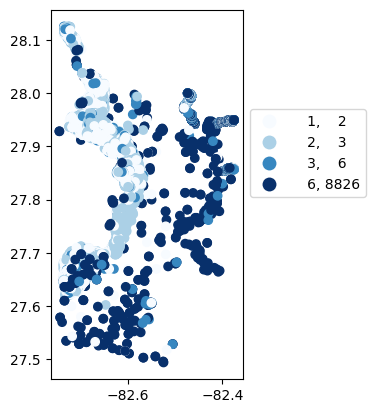

In [44]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

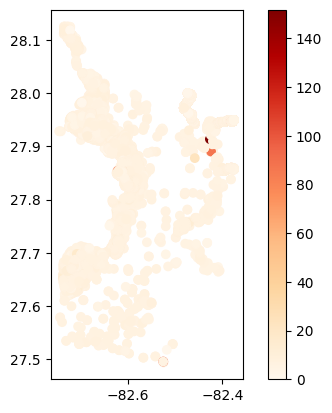

In [45]:
# Map average results at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### pH

-Usable results-
count    276387.000000
mean          7.762071
std           0.472551
min           0.370000
25%           7.520000
50%           7.890000
75%           8.070000
max          12.970000
dtype: float64
Unusable results: 173
Usable results with inferred units: 0
Results outside threshold (0.0 to 10.5973790448676): 7


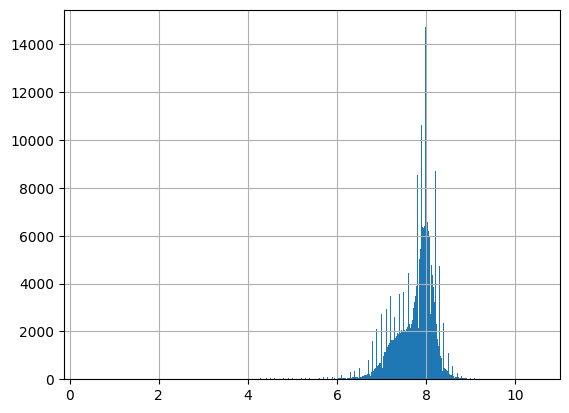

In [46]:
# pH, this time looking at a report
df = harmonize.harmonize(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [47]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
4,7.48,None,NaN,7.48 dimensionless
5,8.18,None,NaN,8.18 dimensionless
7,7.81,None,NaN,7.81 dimensionless
12,7.92,None,NaN,7.92 dimensionless
13,7.8,None,NaN,7.8 dimensionless
...,...,...,...,...
1465641,7.9,std units,NaN,7.9 dimensionless
1465642,7.3,std units,NaN,7.3 dimensionless
1465644,7.8,std units,NaN,7.8 dimensionless
1465645,7.7,std units,NaN,7.7 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

##### Salinity

-Usable results-
count    267183.000000
mean         21.709492
std          95.351598
min          -0.020000
25%          18.050000
50%          24.900000
75%          28.650000
max       48930.000000
dtype: float64
Unusable results: 1252
Usable results with inferred units: 0
Results outside threshold (0.0 to 593.8190792053073): 4


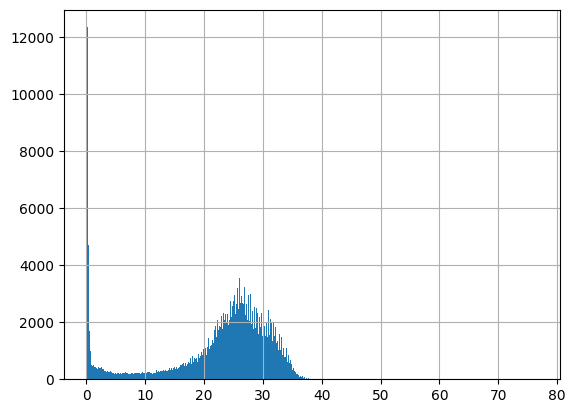

In [48]:
# Salinity
df = harmonize.harmonize(df, 'Salinity', report=True, errors='ignore')

In [49]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
1,40,ppth,NaN,40.0 Practical_Salinity_Units
6,29,PSS,NaN,29.0 Practical_Salinity_Units
8,26.04,PSS,NaN,26.04 Practical_Salinity_Units
15,0.18,ppth,NaN,0.18 Practical_Salinity_Units
17,5.9,ppth,NaN,5.9 Practical_Salinity_Units
...,...,...,...,...
1465333,21.3,PSS,NaN,21.3 Practical_Salinity_Units
1465335,20.97,PSS,NaN,20.97 Practical_Salinity_Units
1465338,19.9,PSS,NaN,19.9 Practical_Salinity_Units
1465344,20.4,PSS,NaN,20.4 Practical_Salinity_Units


##### Nitrogen

-Usable results-
count    163.000000
mean       1.575389
std        4.532429
min        0.024000
25%        0.202720
50%        0.315560
75%        0.500170
max       22.500000
dtype: float64
Unusable results: 2
Usable results with inferred units: 0
Results outside threshold (0.0 to 28.769965070579055): 0


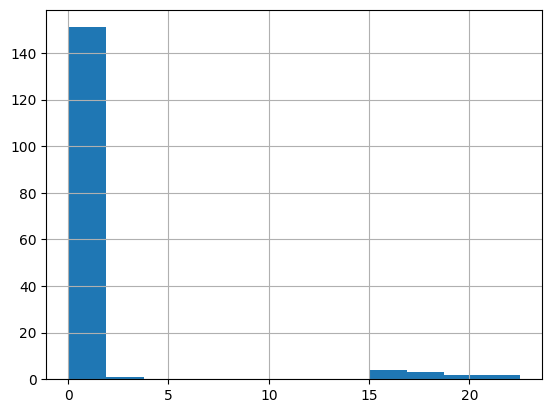

In [50]:
# Nitrogen
df = harmonize.harmonize(df, 'Nitrogen', report=True)

In [51]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
221815,0.39,mg/L,NaN,0.39 milligram / liter
237910,0.4475,mg/L,NaN,0.4475 milligram / liter
240679,0.425,mg/L,NaN,0.425 milligram / liter
254255,0.4625,mg/L,NaN,0.4625 milligram / liter
255860,0.33625,mg/L,NaN,0.33625 milligram / liter
...,...,...,...,...
1463816,0.084,mg/l,NaN,0.084 milligram / liter
1463824,0.166,mg/l,NaN,0.166 milligram / liter
1463834,0.091,mg/l,NaN,0.091 milligram / liter
1463868,0.057,mg/l,NaN,0.057 milligram / liter


##### Conductivity

-Usable results-
count     10.000000
mean     703.700000
std       79.037333
min      606.000000
25%      627.750000
50%      731.500000
75%      775.750000
max      776.000000
dtype: float64
Unusable results: 8
Usable results with inferred units: 0
Results outside threshold (0.0 to 1177.9239977057255): 0


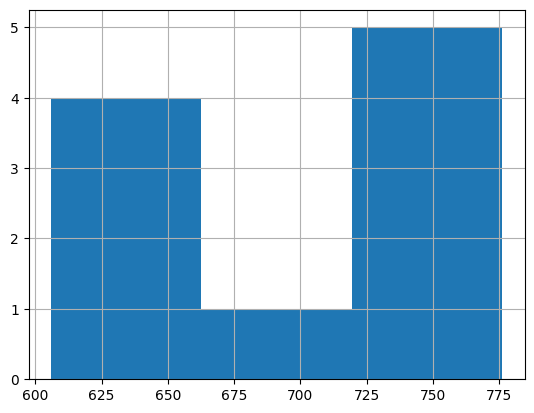

In [52]:
# Conductivity
df = harmonize.harmonize(df, 'Conductivity', report=True)

In [53]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
385072,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
390188,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
391236,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
393815,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
394231,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
396564,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
401375,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
417408,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
479322,626,uS/cm,NaN,626.0 microsiemens / centimeter
483940,688,uS/cm,NaN,688.0 microsiemens / centimeter


##### Chlorophyll a

-Usable results-
count    43333.000000
mean         0.014368
std          0.022741
min         -0.000506
25%          0.004600
50%          0.008720
75%          0.016360
max          1.552000
dtype: float64
Unusable results: 1115
Usable results with inferred units: 4
Results outside threshold (0.0 to 0.15081314171981786): 197


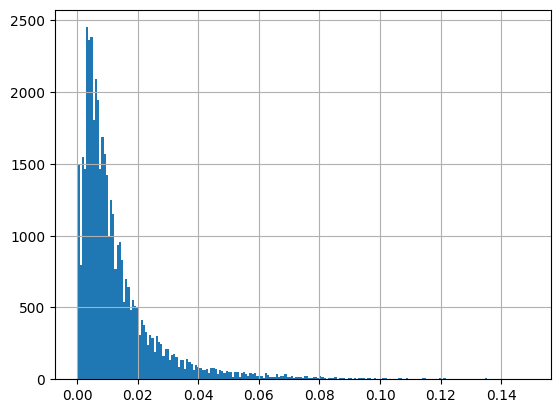

In [54]:
# Chlorophyll a
df = harmonize.harmonize(df, 'Chlorophyll a', report=True)

In [55]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
220687,5.94,ug/L,NaN,0.005940000000000001 milligram / liter
225841,1.45,ug/L,NaN,0.00145 milligram / liter
226736,2.77,ug/L,NaN,0.00277 milligram / liter
228074,3.87,ug/L,NaN,0.00387 milligram / liter
235704,8.15,ug/L,NaN,0.008150000000000001 milligram / liter
...,...,...,...,...
1465325,18.16,ug/l,NaN,0.01816 milligram / liter
1465326,41.09,ug/l,NaN,0.04109 milligram / liter
1465337,23.55,ug/l,NaN,0.02355 milligram / liter
1465339,37.07,ug/l,NaN,0.03707 milligram / liter


##### Organic Carbon

-Usable results-
count    2.159900e+04
mean     2.459375e+04
std      1.903944e+06
min      0.000000e+00
25%      4.600000e+00
50%      7.100000e+00
75%      1.200000e+01
max      2.000000e+08
dtype: float64
Unusable results: 1928
Usable results with inferred units: 0
Results outside threshold (0.0 to 11448260.421998743): 8


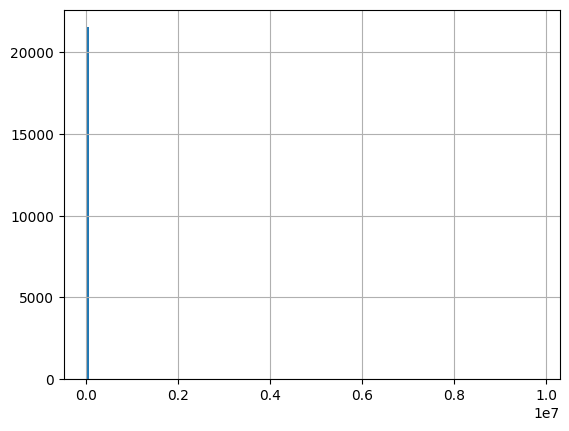

In [56]:
# Organic carbon (%)
df = harmonize.harmonize(df, 'Organic carbon', report=True)

In [57]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
3,3.8,mg/L,NaN,3.8 milligram / liter
68,28.0,mg/L,NaN,28.0 milligram / liter
272,3.4,mg/L,NaN,3.4 milligram / liter
287,6.7,mg/L,NaN,6.7 milligram / liter
346,5.8,mg/L,NaN,5.8 milligram / liter
...,...,...,...,...
1462880,0.83,mg/l,NaN,0.83 milligram / liter
1462930,0.71,mg/l,NaN,0.71 milligram / liter
1462937,1.43,mg/l,NaN,1.43 milligram / liter
1462945,0.90,mg/l,NaN,0.9 milligram / liter


##### Turbidity (NTU)

-Usable results-
count     92686.00000
mean         16.13425
std         870.34539
min          -0.04770
25%           1.50000
50%           2.40000
75%           4.08000
max      200000.00000
dtype: float64
Unusable results: 1100
Usable results with inferred units: 0
Results outside threshold (0.0 to 5238.206591642857): 155


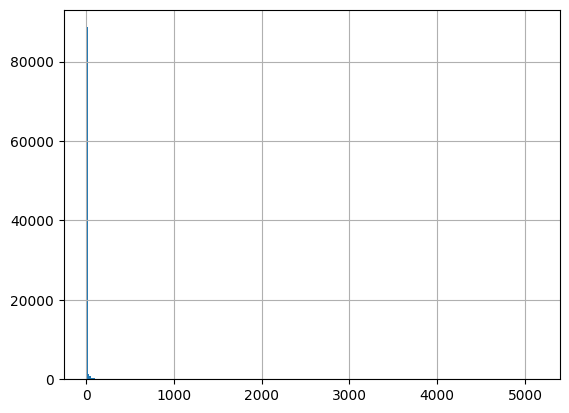

In [58]:
# Turbidity (NTU)
df = harmonize.harmonize(df, 'Turbidity', report=True, errors='ignore')

In [59]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
120,2.3,NTU,NaN,2.3 Nephelometric_Turbidity_Units
143,2.6,NTU,NaN,2.6 Nephelometric_Turbidity_Units
284,0.9,NTU,NaN,0.9 Nephelometric_Turbidity_Units
296,3.0,NTU,NaN,3.0 Nephelometric_Turbidity_Units
313,2.0,NTU,NaN,2.0 Nephelometric_Turbidity_Units
...,...,...,...,...
1462881,0.2,NTRU,NaN,0.2 Nephelometric_Turbidity_Units
1462931,2.1,NTRU,NaN,2.1 Nephelometric_Turbidity_Units
1462938,0.4,NTRU,NaN,0.4 Nephelometric_Turbidity_Units
1462946,2.0,NTRU,NaN,2.0 Nephelometric_Turbidity_Units


##### Sediment

In [60]:
# Sediment
df = harmonize.harmonize(df, 'Sediment', report=False)

In [61]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment


##### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [62]:
# Phosphorus
df = harmonize.harmonize(df, 'Phosphorus')

2 Phosphorus sample fractions not in frac_dict


2 Phosphorus sample fractions not in frac_dict found in expected domains, mapped to "Other_Phosphorus"


Note: warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [63]:
# All Phosphorus
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']
df.loc[df['Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
3379,0.049,mg/L,NaN,NaN
7735,0.004,mg/L,NaN,NaN
9147,0.049,mg/L,NaN,NaN
10947,0.036,mg/L,NaN,NaN
19519,0.050,mg/L,NaN,0.05 milligram / liter
...,...,...,...,...
1464113,0.065,mg/l as P,NaN,NaN
1464118,0.027,mg/l as P,NaN,NaN
1464124,0.04,mg/l as P,NaN,NaN
1464139,0.05,mg/l as P,NaN,NaN


In [64]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
3379,0.049,mg/L,NaN,NaN
7735,0.004,mg/L,NaN,NaN
9147,0.049,mg/L,NaN,NaN
10947,0.036,mg/L,NaN,NaN
23387,0.004,mg/L,NaN,NaN
...,...,...,...,...
1464113,0.065,mg/l as P,NaN,NaN
1464118,0.027,mg/l as P,NaN,NaN
1464124,0.04,mg/l as P,NaN,NaN
1464139,0.05,mg/l as P,NaN,NaN


In [65]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
19519,0.050,mg/L,NaN,0.05 milligram / liter
29585,0.009,mg/L,NaN,0.009 milligram / liter
56022,0.003,mg/L,NaN,0.003 milligram / liter
65531,0.050,mg/L,NaN,0.05 milligram / liter
70682,0.002,mg/L,NaN,0.002 milligram / liter
...,...,...,...,...
1451036,1.0,mg/l as P,NaN,1.0 milligram / liter
1451054,0.93,mg/l as P,NaN,0.93 milligram / liter
1451072,0.58,mg/l as P,NaN,0.58 milligram / liter
1451096,0.48,mg/l as P,NaN,0.48 milligram / liter


In [66]:
# All other phosphorus sample fractions
df.loc[df['Other_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
221968,0.13118375,mg/L,NaN,NaN
238400,0.1696225,mg/L,NaN,NaN
239076,0.0835825,mg/L,NaN,NaN
245328,0.16950375,mg/L,NaN,NaN
255041,0.03524375,mg/L,NaN,NaN
...,...,...,...,...
1438772,0.058,%,NaN,NaN
1439629,0.041,%,NaN,NaN
1440409,0.078,%,NaN,NaN
1462701,460,mg/kg,NaN,NaN


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count    8.647000e+03
mean     4.903257e+03
std      1.318438e+05
min      0.000000e+00
25%      3.000000e+00
50%      1.100000e+01
75%      6.000000e+01
max      1.000000e+07
dtype: float64
Unusable results: 55551
Usable results with inferred units: 5
Results outside threshold (0.0 to 795966.1242988213): 8


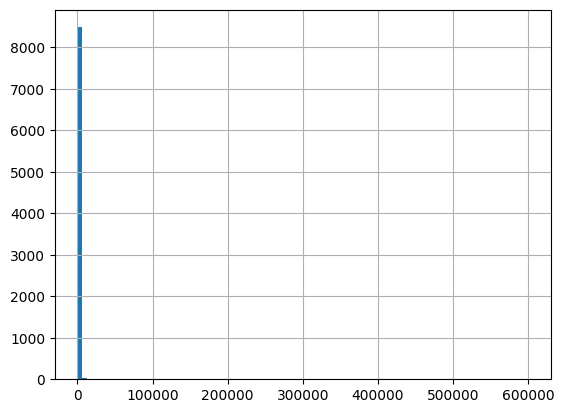

In [67]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Fecal Coliform', report=True, errors='ignore')

In [68]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
10,760,cfu/100mL,NaN,NaN
31,300,#/100mL,NaN,NaN
41,280,#/100mL,NaN,NaN
62,5,cfu/100mL,NaN,NaN
65,260,#/100mL,NaN,NaN
...,...,...,...,...
1457975,100.0,cfu/100ml,NaN,100.0 Colony_Forming_Units / milliliter
1458014,1100.0,cfu/100ml,NaN,1100.0 Colony_Forming_Units / milliliter
1458102,300.0,cfu/100ml,NaN,300.0 Colony_Forming_Units / milliliter
1458156,160.0,cfu/100ml,NaN,160.0 Colony_Forming_Units / milliliter


###### Excherichia Coli

/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count      142.000000
mean       976.669014
std       4473.446618
min          0.000000
25%         21.000000
50%         46.000000
75%        120.000000
max      41000.000000
dtype: float64
Unusable results: 6109
Usable results with inferred units: 0
Results outside threshold (0.0 to 27817.348725062726): 1


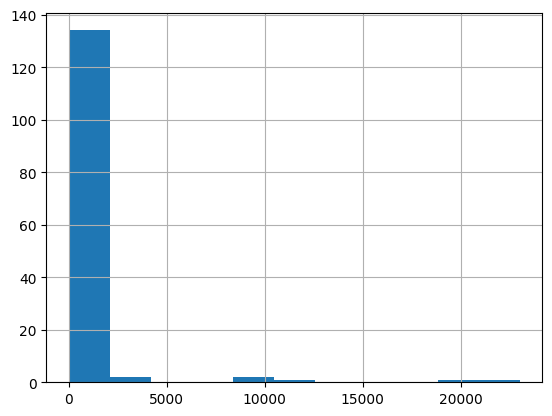

In [69]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Escherichia coli', report=True, errors='ignore')

In [70]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
276034,210,MPN/100mL,NaN,NaN
277432,4800,MPN/100mL,NaN,NaN
277854,74.5,MPN/100mL,NaN,NaN
277993,553.9,MPN/100mL,NaN,NaN
278267,87,MPN/100mL,NaN,NaN
...,...,...,...,...
1460488,219,MPN/100mL,NaN,NaN
1460533,Not Reported,MPN/100mL,"ResultMeasureValue: ""Not Reported"" result cann...",NaN
1460546,Not Reported,MPN/100mL,"ResultMeasureValue: ""Not Reported"" result cann...",NaN
1460559,59.1,MPN/100mL,NaN,NaN


#### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

Explore Salinity results:

In [71]:
from harmonize_wq import convert

In [72]:
# Salinity summary statistics
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: -0.02 to 48930.0
Results: 267183 
Mean: 21.709491748587812 PSU


In [73]:
# Identify extreme outliers
[x for x in lst if x >3200]

[48930.0]

Other fields like units and QA_flag may help understand what caused high values and what results might need to be dropped from consideration

In [74]:
# Columns to focus on
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']

In [75]:
# Look at important fields for max 5 values
salinity_series = df['Salinity'][df['Salinity'].notna()]
salinity_series.sort_values(ascending=False, inplace=True)
df[cols][df['Salinity'].isin(salinity_series[0:5])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
288161,48930,ppth,NaN,48930.0 Practical_Salinity_Units
434311,76.57,ppth,NaN,76.57 Practical_Salinity_Units
497046,54.8,ppth,NaN,54.8 Practical_Salinity_Units
620827,2976,ppth,NaN,2976.0 Practical_Salinity_Units
645813,68,ppth,NaN,68.0 Practical_Salinity_Units


Detection limits may help understand what caused low values and what results might need to be dropped or updated

In [76]:
df = wrangle.add_detection(df, 'Salinity')
cols+=['ResultDetectionConditionText',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode']

In [77]:
# Look at important fields for min 5 values (often multiple 0.0)
df[cols][df['Salinity'].isin(salinity_series[-5:])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,ResultDetectionConditionText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode
25321,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Lower Quantitation Limit,5.0,ppth
25322,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Method Detection Level,1.0,ppth
46498,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Lower Quantitation Limit,5.0,ppth
46499,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Method Detection Level,1.0,ppth
373948,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
551972,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
561300,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
737406,-0.02,ppth,NaN,-0.02 Practical_Salinity_Units,NaN,NaN,NaN,NaN
968155,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
970962,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN


Explore Conductivity results:

In [78]:
# Create series and inspect Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

481429    626.0 microsiemens / centimeter
486072    688.0 microsiemens / centimeter
503763    606.0 microsiemens / centimeter
504635    606.0 microsiemens / centimeter
507781    633.0 microsiemens / centimeter
577362    775.0 microsiemens / centimeter
580144    776.0 microsiemens / centimeter
581124    776.0 microsiemens / centimeter
583254    776.0 microsiemens / centimeter
588592    775.0 microsiemens / centimeter
Name: Conductivity, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm, use a higher threshold for coastal waters

In [79]:
# Sort and check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.sort_values(by=['Conductivity'], ascending=False, inplace=True)
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
580144,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
581124,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
583254,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
577362,775,uS/cm,NaN,NaN,775.0 microsiemens / centimeter
588592,775,uS/cm,NaN,NaN,775.0 microsiemens / centimeter
486072,688,uS/cm,NaN,NaN,688.0 microsiemens / centimeter
507781,633,uS/cm,NaN,NaN,633.0 microsiemens / centimeter
481429,626,uS/cm,NaN,NaN,626.0 microsiemens / centimeter
503763,606,uS/cm,NaN,NaN,606.0 microsiemens / centimeter
504635,606,uS/cm,NaN,NaN,606.0 microsiemens / centimeter


In [80]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

580144    0.379 dimensionless
581124    0.379 dimensionless
583254    0.379 dimensionless
577362    0.379 dimensionless
588592    0.379 dimensionless
486072    0.335 dimensionless
507781    0.308 dimensionless
481429    0.304 dimensionless
503763    0.294 dimensionless
504635    0.294 dimensionless
Name: Salinity, dtype: object

#### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [81]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
580144,2007-08-15,NaN,NaN
581124,2007-08-15,NaN,NaN
583254,2007-08-15,NaN,NaN
577362,2007-08-15,NaN,NaN
588592,2007-08-15,NaN,NaN
...,...,...,...
1469287,1955-04-08,NaN,NaN
1469288,1955-04-08,NaN,NaN
1469289,1957-10-21,14:05:00,EST
1469290,1955-04-08,NaN,NaN


In [82]:
# 'ActivityStartDate' presserves date where 'Activity_datetime' is NAT due to no time zone
df = clean.datetime(df)
df[['ActivityStartDate', 'Activity_datetime']]

/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/dataretrieval/utils.py:87: UserWarning: Warning: 100662 incomplete dates found, consider setting datetime_index to False.
  warnings.warn(


,ActivityStartDate,Activity_datetime
580144,2007-08-15,NaT
581124,2007-08-15,NaT
583254,2007-08-15,NaT
577362,2007-08-15,NaT
588592,2007-08-15,NaT
...,...,...
1469287,1955-04-08,NaT
1469288,1955-04-08,NaT
1469289,1957-10-21,1957-10-21 19:05:00+00:00
1469290,1955-04-08,NaT


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a ActivityStartDate column is used to preserve date only.

#### Depth

Note: Data are often lacking sample depth metadata

In [83]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

486072     0.95
507781     0.50
481429     0.00
377563     0.10
378566     0.10
           ... 
1363579    0.33
1412499    0.33
1413031    0.30
1414919    0.30
1417055    0.33
Name: ResultDepthHeightMeasure/MeasureValue, Length: 495, dtype: float64

#### Characteristic to Column (long to wide format)

In [84]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,QA_pH,QA_Temperature,QA_E_coli,QA_Salinity,QA_Nitrogen,QA_Conductivity,QA_Fecal_Coliform,QA_DO,QA_Carbon,QA_Turbidity
580144,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:2,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-183201126,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
581124,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3.3,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-183201150,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583254,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-183201135,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
577362,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:1,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-183201115,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
588592,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:0,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-183201107,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469287,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6842541,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1469288,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6842544,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1469289,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800924,1957-10-21,14:05:00,-0500,USGS-02306001,NWIS-6894410,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1469290,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500782,1955-04-08,NaN,NaN,USGS-274455082253601,NWIS-6842941,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

14 new columns


In [86]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

68677 fewer rows


In [87]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [88]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [89]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'TOTAL NITROGEN_ MIXED FORMS', 'Conductivity',
       'Chlorophyll', 'Carbon', 'Turbidity', 'Sediment', 'Phosphorus',
       'TP_Phosphorus', 'TDP_Phosphorus', 'Other_Phosphorus', 'Fecal_Coliform',
       'E_coli', 'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode',
       'Activity_datetime', 'Depth', 'QA_TP_Phosphorus', 'QA_TDP_Phosphorus',
       'QA_Other_Phosphorus', 'QA_Secchi', 'QA_Chlorophyll', 'QA_pH',
       'QA_Temperature', 'QA_E_coli', 'QA_Salinity', 'QA_Nitrogen',
       'QA_Conductivity', 'QA_Fecal_Coliform', 'QA_DO', 'QA_Carbon',
       'QA_Turbidity'],
      dtype='object')

In [90]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Secchi,Temperature,DO,pH,Salinity,...,QA_pH,QA_Temperature,QA_E_coli,QA_Salinity,QA_Nitrogen,QA_Conductivity,QA_Fecal_Coliform,QA_DO,QA_Carbon,QA_Turbidity
580144,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:2,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
581124,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3.3,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583254,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
577362,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:1,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
588592,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:0,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['Sediment',
 'QA_TDP_Phosphorus',
 'QA_Other_Phosphorus',
 'QA_pH',
 'QA_Temperature',
 'QA_E_coli',
 'QA_Salinity',
 'QA_Nitrogen',
 'QA_Conductivity',
 'QA_DO',
 'QA_Carbon',
 'QA_Turbidity']

<Axes: >

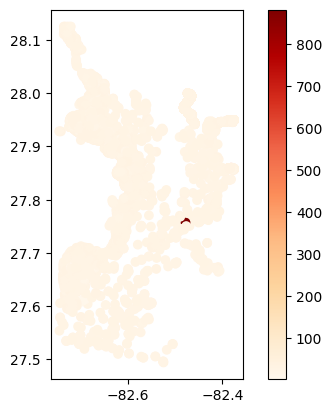

In [92]:
# Map average temperature at each station
results_gdf = visualize.map_measure(main_df, stations_clipped, 'Temperature')
results_gdf.plot(column='mean', cmap='OrRd', legend=True)